# Model Building Phase 1

Welcome to the comprehensive notebook for training a transformer-based text classifier to predict mental health labels from textual statements.  
This notebook demonstrates the **complete deep learning workflow** leveraging Hugging Face Transformers and PyTorch, optimized to run on Google Colab for maximum speed and hardware efficiency.

## About this Notebook

With the ever-increasing scale of natural language datasets and model sizes, traditional methods of training on local hardware face severe bottlenecks—especially when experimenting with models like BERT or DistilBERT.  
Google Colab provides free access to powerful NVIDIA GPUs, making it the ideal platform for resource-intensive NLP tasks.  
This notebook takes you through every step required to develop, train, and validate a high-performance text classifier and ensures your key artifacts (model weights, reports, checkpoints) are safely stored for further use.


## 1. Environment & Dependency Setup

In [1]:
!pip uninstall -y torch torchvision torchaudio transformers huggingface_hub diffusers gradio pyarrow fsspec websockets numpy pandas
!pip install --upgrade pip
!pip install numpy==1.26.4 pandas==2.2.3 pyarrow==14.0.1 fsspec==2025.3.0
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers==4.45.1 huggingface-hub==0.26.2 datasets==3.0.2 accelerate==1.1.1
!pip install websockets==13.0 emoji textblob sentence-transformers spacy
!python -m spacy download en_core_web_sm
import torch, transformers, datasets, spacy, numpy, pandas
print("✅ All libraries installed successfully!")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("SpaCy:", spacy.__version__)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)


Found existing installation: torch 2.9.0
Uninstalling torch-2.9.0:
  Successfully uninstalled torch-2.9.0
Found existing installation: transformers 4.45.1
Uninstalling transformers-4.45.1:
  Successfully uninstalled transformers-4.45.1
Found existing installation: huggingface-hub 0.26.2
Uninstalling huggingface-hub-0.26.2:
  Successfully uninstalled huggingface-hub-0.26.2
Found existing installation: pyarrow 21.0.0
Uninstalling pyarrow-21.0.0:
  Successfully uninstalled pyarrow-21.0.0
Found existing installation: fsspec 2024.9.0
Uninstalling fsspec-2024.9.0:
  Successfully uninstalled fsspec-2024.9.0
Found existing installation: websockets 13.0
Uninstalling websockets-13.0:
  Successfully uninstalled websockets-13.0
Found existing installation: numpy 2.3.4
Uninstalling numpy-2.3.4:
  Successfully uninstalled numpy-2.3.4
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.4.1 (from versions: 2.6.0+cu126, 2.7.0+cu126, 2.7.1+cu126, 2.8.0+cu126, 2.9.0+cu126)
ERROR: No matching distribution found for torch==2.4.1
  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached pyarrow-21.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
Using cached huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
Using cached pyarrow-21.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (42.8 MB)
Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl (899.7 MB)
  Attempting uninstall: pyarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.3 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ All libraries installed successfully!
Torch: 2.9.0+cu128
CUDA available: True
GPU device: Tesla T4
Transformers: 4.45.1
Datasets: 3.0.2
SpaCy: 3.8.7
NumPy: 2.3.4
Pandas: 2.2.3


In [1]:
from huggingface_hub import login
login(new_session=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 2. Importing Libraries

In [2]:
import time
print("Code start: Environment setup...")
start = time.time()
from torch.nn import CrossEntropyLoss
from google.colab import files
import os
import shutil
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns

print("Imported libraries successfully.")
print("Code finished in", round(time.time() - start, 2), "seconds.")

Code start: Environment setup...
Imported libraries successfully.
Code finished in 3.54 seconds.


## 3. Load Data & Tokenizer
Upload your CSV dataset with text statements and labels. Verifies successful upload and loads the data into memory for pre-processing. Initialize the DistilBERT tokenizer for converting text into model-ready format and encode string labels to integer indices.

In [4]:
from google.colab import files
uploaded = files.upload()   # opens file picker

# uploaded is a dict: filename -> bytes. After upload the file sits in /content/
import pandas as pd
df = pd.read_csv('features_interpretable.csv')   # or next(iter(uploaded.keys()))
print(df.shape)


Saving features_interpretable.csv to features_interpretable (2).csv
(45261, 21)


In [5]:
print("Code start: Load data and tokenizer...")
start = time.time()

df = pd.read_csv('features_interpretable.csv')

tokenizer = AutoTokenizer.from_pretrained(
    "mental/mental-bert-base-uncased",
    cache_dir="./cache"
)

label_map = {label: i for i, label in enumerate(df['status'].unique())}
df['label_id'] = df['status'].map(label_map)

print(f"Loaded {df.shape[0]} samples and tokenizer.")
print("Code finished in", round(time.time() - start, 2), "seconds.")


Code start: Load data and tokenizer...


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loaded 45261 samples and tokenizer.
Code finished in 1.27 seconds.


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 4. Dataset & DataLoader Preparation
Wraps the tokenization and batching logic in a custom Dataset. Batches are loaded efficiently for both training and validation.

In [6]:
print("Code start: Preparing Dataset and DataLoader...")
start = time.time()

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df['statement'].tolist(),
    df['label_id'].tolist(),
    stratify=df['label_id'],
    test_size=0.2,
    random_state=42
)

train_ds = MentalHealthDataset(X_train, y_train, tokenizer)
val_ds = MentalHealthDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=2, pin_memory=True)

print("Prepared DataLoaders.")
print("Code finished in", round(time.time() - start, 2), "seconds.")


Code start: Preparing Dataset and DataLoader...
Prepared DataLoaders.
Code finished in 0.05 seconds.


## 5. Model Initialization
Configures the DistilBERT model for classification on your task and sets up the optimizer and learning rate scheduler.


In [7]:
print("Code start: Initializing Model...")
start = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    "mental/mental-bert-base-uncased",
    num_labels=len(label_map)
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

epochs = 3
total_steps = len(train_loader) * epochs  # ensure train_loader exists
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Model initialized on {device}")
print("Code finished in", round(time.time() - start, 2), "seconds.")


Code start: Initializing Model...
Using device: cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized on cuda:0
Code finished in 3.12 seconds.


*Decision Note: Selecting DistilBERT balances model power and inference/training speed—critical for practical, scalable NLP projects.*

## 6. Training Loop & Checkpointing
Trains the model with progress printing and saves checkpoints at each epoch so you can resume or revert at any time.



In [8]:
print("Code start: Training loop & checkpointing...")
start = time.time()

loss_fn = CrossEntropyLoss()

# Directory to save checkpoints
checkpoint_dir = "mental_bert_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")

    # Save checkpoints
    model_path = os.path.join(checkpoint_dir, f"distilbert_epoch{epoch+1}.pth")
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pth")

    torch.save(model.state_dict(), model_path)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
    }, checkpoint_path)

    print(f"Epoch {epoch+1} finished in {round(time.time() - start, 2)} seconds.")

# Zip all checkpoints
zip_name = "mental_bert_checkpoints.zip"
shutil.make_archive("mental_bert_checkpoints", 'zip', checkpoint_dir)

# Download the zipped folder
files.download(zip_name)

print("All checkpoints zipped and downloaded successfully.")
print("Code finished in", round(time.time() - start, 2), "seconds.")


Code start: Training loop & checkpointing...
Epoch 1 Train Loss: 0.5187
Epoch 1 finished in 806.85 seconds.
Epoch 2 Train Loss: 0.3088
Epoch 2 finished in 1611.9 seconds.
Epoch 3 Train Loss: 0.2095
Epoch 3 finished in 2415.64 seconds.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All checkpoints zipped and downloaded successfully.
Code finished in 2688.53 seconds.


*Decision Note: Initialization must match the number of classes to the output layer.*

## 7. Model Validation and Report
Evaluates the trained model on the held-out validation set, reporting per-class classification metrics.

In [9]:
print("Code start: Validation...")
start = time.time()

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("Validation Accuracy:", round(acc, 4))
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

print("Code finished in", round(time.time() - start, 2), "seconds.")


Code start: Validation...
Validation Accuracy: 0.8489
                      precision    recall  f1-score   support

             Anxiety       0.87      0.90      0.89       621
              Normal       0.96      0.96      0.96      3198
          Depression       0.82      0.74      0.78      2421
            Suicidal       0.72      0.81      0.76      1762
              Stress       0.75      0.81      0.78       469
             Bipolar       0.88      0.85      0.86       424
Personality disorder       0.74      0.68      0.71       158

            accuracy                           0.85      9053
           macro avg       0.82      0.82      0.82      9053
        weighted avg       0.85      0.85      0.85      9053

Code finished in 62.27 seconds.


*Decision Note: Compare to classical benchmarks, focus on minority class metrics.*

**Interpretation (Validation Results):**

The DistilBERT classifier achieves strong balanced accuracy (84.9%) across multiple mental health categories.  
It is highly reliable for 'Normal' cases and performs well for Anxiety, Bipolar, Depression, and Stress.

Recall is lower for Depression and Personality disorder, indicating some missed cases.  
Performance on "Suicidal" is reasonable but could be improved for safety-critical detection.

This model is suitable for screening and large-scale triage.  
Further gains may be realized by balancing data or refining preprocessing, especially for minority and overlapping classes.


## 8. Results Visualisation
Visual display of predictions highlights strengths and weaknesses across all categories for further analysis.

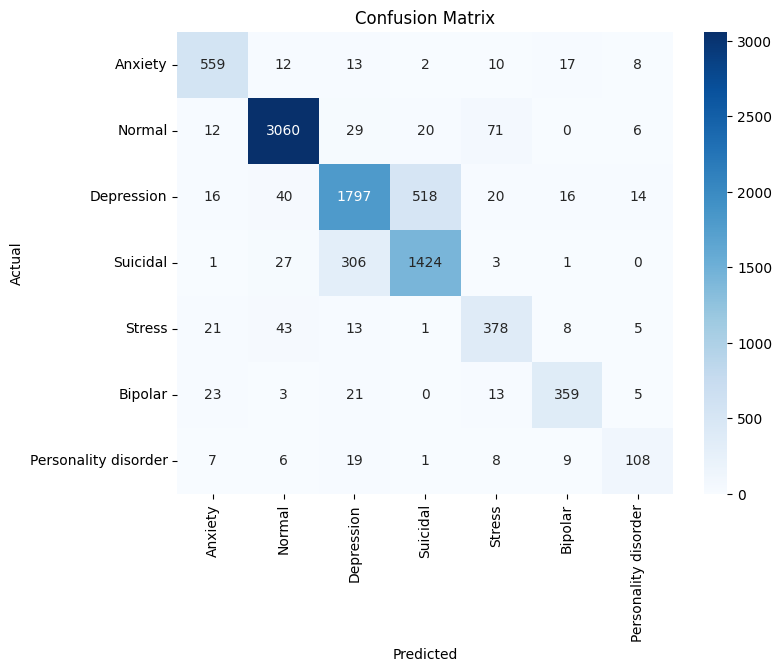

In [10]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix Interpretation:**

The confusion matrix shows that most predictions fall on the diagonal, indicating strong overall classification for each class.  
"Normal," "Anxiety," and "Suicidal" are identified with high accuracy, with only moderate confusion among related mental health conditions, such as between "Depression" and "Suicidal."  
Misclassifications are most common in minority classes like "Personality disorder," showing the model could benefit from more data or targeted balancing for these groups.

The matrix confirms reliable detection for major categories and highlights areas (e.g., Depression vs. Suicidal, Personality disorder) needing further improvement.


## 9. Next Step: Baseline Model Testing

**Description:**  
Evaluate the existing 7-class model on a held-out test set to establish an unbiased performance baseline.

**Decision Note:**  
Testing before any modifications prevents data leakage and provides a true measure of current model generalization.

**Interpretation:**  
The resulting test metrics will serve as a reference point for all subsequent refinements, ensuring that scope reduction and hyperparameter tuning yield measurable improvements.  
